## Задача (18 pts)

Рассмотрим следующую задачу

$$ \min_x \|x - y \|_2^2 + \lambda \sum_{i=0}^{n-1} \left(\sqrt{\varepsilon^2 + (x_{i+1} - x_i)^2} - \varepsilon\right),$$

где $y$ данный вектор, $\lambda >0 $ и $\varepsilon > 0$ заданные числа. 

- (5 pts) Решите эту задачу с помощью пакета cvxpy. Проверьте, что найденное решение удовлетворяет условию оптимальности для этой задачи.

- (5 pts) Сравните для этой задачи скорость сходимости (по итерациям и по времени) градиентного спуска для
    - адаптивного метода выбора шага
    - 3 постоянных шагов (убедитесь что они все приводят к сходимости)

Прокомментируйте и объясните полученный результат.


- (3 pts) Нарисуйте на одном графике векторы $y$ и $x^*$. Что вы заметили?
- (5 pts) Повторите эксперименты для $\varepsilon = 10^{-2}$ и $\varepsilon = 10^{-4}$. Что изменилось в результате и сходимости градиентного спуска и почему? Какую роль играет этот параметр в постановке задачи?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000
EPSILON = 0.001
LAMBDA = 50

y = np.hstack([np.ones(1000) + 0.1 * np.random.randn(1000), 5 * np.ones(1000) + 0.1 *np.random.randn(1000),
                   -3*np.ones(1000) + 0.1 *np.random.randn(1000), -2 * np.ones(1000) + 0.1 *np.random.randn(1000),
                  3 * np.ones(1000) + 0.1 *np.random.randn(1000)])
#plt.plot(y)

In [2]:
def grad(x):
    # Cоставляем основное тело градиента (краевые точки будут неверными , их далее исправим)
    result = LAMBDA*( (x-np.roll(x,1)) / np.sqrt( EPSILON**2+(x-np.roll(x,1))**2 )
                    +  (x-np.roll(x,-1)) /np.sqrt( EPSILON**2+(np.roll(x,-1)-x)**2 )  )
    
    result = np.delete(result,0)#Удаляем первую компоненту и на ее место вставялем правильное значение
    result = np.insert(result , 0, LAMBDA*((x[0]-x[1])/ np.sqrt(EPSILON**2+(x[1]-x[0])**2 ) ) )
    
    result = np.delete(result , -1)#Удаляем последнюю компоненту и на ее место вставялем правильное значение
    result = np.append(result, LAMBDA*((x[-1]-x[-2])/ np.sqrt(EPSILON**2+(x[-1]-x[-2])**2 ) ) )
    
    result = result + 2*(x-y) #В конце к заготовке прибавляем производую второй нормы(ко всем компонентам)
    
    return result   

### Решение через CVXPY

In [3]:
import cvxpy as cvx

x = cvx.Variable(len(y))

def f_cvx(x):
    return cvx.norm(x - y, 2)**2 + LAMBDA * cvx.sum(cvx.norm2(cvx.vstack((cvx.diff(x), np.ones(n-1)*EPSILON)), axis = 0) - EPSILON)

obj = cvx.Minimize(f_cvx(x))
prob = cvx.Problem(obj)

prob.solve(max_iters=5000 ,solver='ECOS')

print('Время на решение: {}'.format(prob.solution.attr['solve_time']))
print('Кол-во итераций: {}'.format(prob.solution.attr['num_iters']))
print('Невязка: {}'.format(prob.solution.attr['solver_specific_stats']['info']['pres']))
print('Решение: {}'.format(x.value))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x.value)) ) )
print('Значение функции в точке решения = {}'.format(prob.value))

Время на решение: 0.201486649
Кол-во итераций: 25
Невязка: 5.789618080020131e-09
Решение: [1.00069174 1.00069223 1.00069432 ... 3.00195336 3.00195082 3.00194542]
Длина градиента в последней точке алгоритма : 0.000690901571584593
Значение функции в точке решения = 913.8784061562367


Text(0.5, 1.0, 'Решение CVXPY на фоне вектора Y')

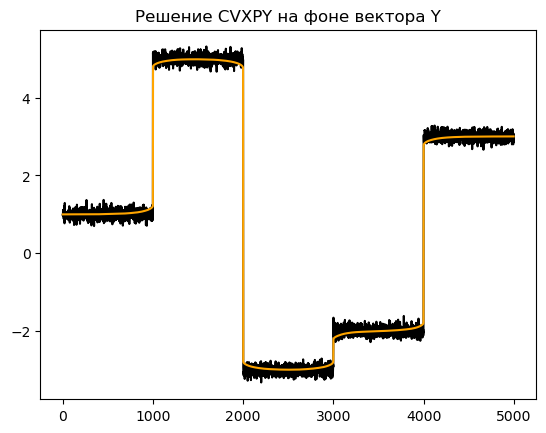

In [4]:
plt.plot(y , color = 'Black')
plt.plot(x.value , color = 'Orange')
plt.title('Решение CVXPY на фоне вектора Y')

### Вывод :
    Норма градиента в решении CVXPY околонулевая и для вектора размерности 5000 вполне адекватаня.
    Можно сказать , что мы находимся в оптимуме. Аналогичный вывод и для дальнейших применений солвера 
    при других эпсилонах


## GD c alpha=const

In [5]:
def f(x):
    return np.sum((x-y)**2) + LAMBDA*(np.sum( np.sqrt( (EPSILON**2)+(np.delete(x,0) - np.delete(x,-1))**2 ) - EPSILON ))


  


def gradient_descent(grad, x0, maxiter, tol, alpha):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(maxiter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        x = x - alpha * g
        conv.append(x.copy())
    return x, conv

#### Стартовую точку не меняем для чистоты экспеимента

In [6]:
np.random.seed(51)
x0 = np.random.randn(n)

#### Первый вариант параметров

In [7]:
tol = 1e-5 
max_iter = 100000
alpha = 0.000003
x1_gd, x1_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x1_gd))
print('Кол-во итераций: {}'.format(len(x1_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x1_gd)) ) )


Решение: [0.42131547 0.42131476 0.42131444 ... 1.40591607 1.40591624 1.40591219]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 240.25024113814803


#### Второй вариант параметров

In [8]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.000001
x2_gd, x2_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x2_gd))
print('Кол-во итераций: {}'.format(len(x2_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x2_gd)) ) )


Решение: [0.1421712  0.1421696  0.14216749 ... 0.54548787 0.54542872 0.54539504]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 372.2568150814358


#### Третий вариант параметров

In [9]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.0000009
x3_gd, x3_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x3_gd))
print('Кол-во итераций: {}'.format(len(x3_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x3_gd)) ) )


Решение: [0.12615234 0.1261488  0.12614281 ... 0.4809256  0.48086118 0.48082487]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 385.2175424323769


Text(0.5, 1.0, 'Решение через GD')

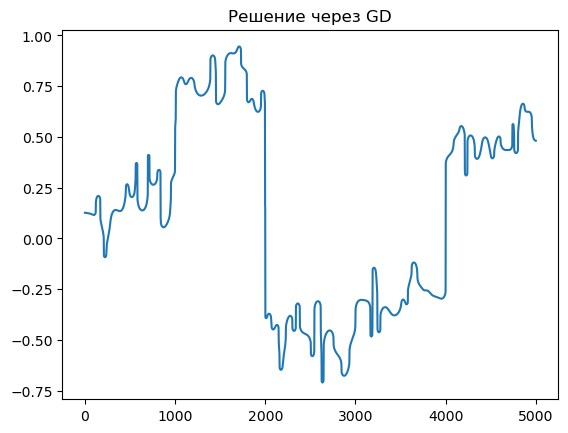

In [10]:
plt.plot(x3_gd)
plt.title('Решение через GD')

Text(0.5, 1.0, 'Сходимость первого варианта параметров')

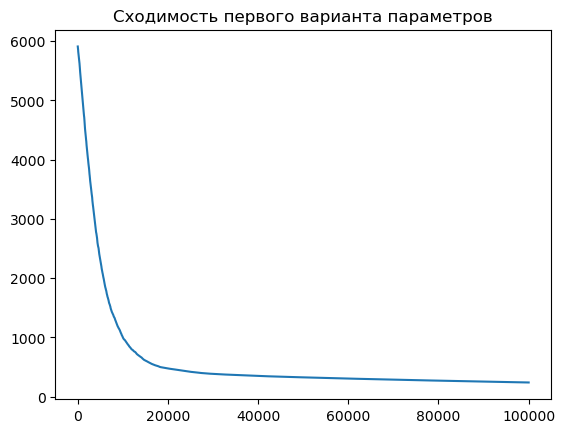

In [11]:
plt.plot([np.linalg.norm(grad(i)) for i in x1_conv_gd ])
plt.title('Сходимость первого варианта параметров')

Text(0.5, 1.0, 'Сходимость второго варианта параметров')

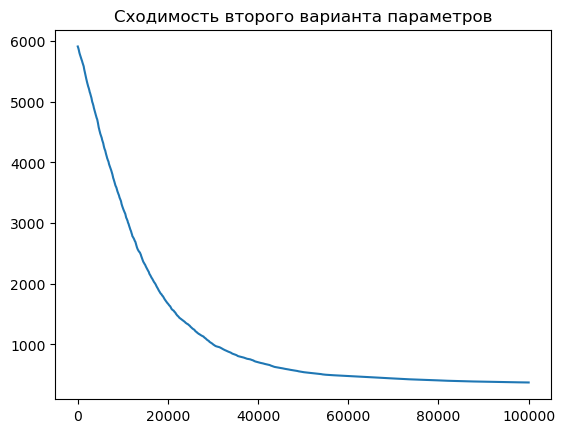

In [12]:
plt.plot([np.linalg.norm(grad(i)) for i in x2_conv_gd ])
plt.title('Сходимость второго варианта параметров')

Text(0.5, 1.0, 'Сходимость третьего варианта параметров')

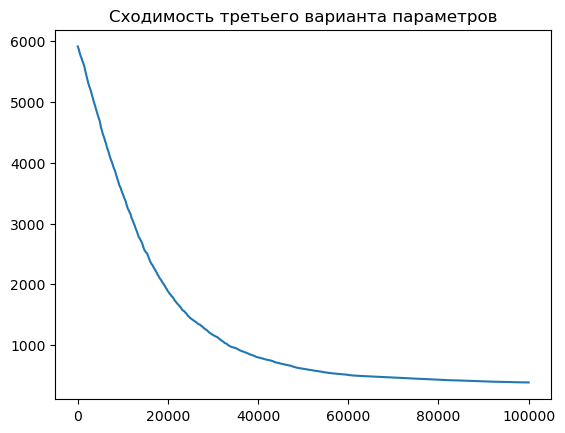

In [13]:
plt.plot([np.linalg.norm(grad(i)) for i in x3_conv_gd ])
plt.title('Сходимость третьего варианта параметров')

## GD c адаптивной alpha 

In [14]:
def adaptive_gradient_descent(grad, x0, maxiter, tol):
    
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(maxiter):
        g = grad(x)
        best_func_value = np.inf
        alpha = 1 
        for i in range(50): 
            if f(x - alpha * g) < best_func_value:
                best_alpha = alpha
                best_func_value = f(x - alpha * g)
                alpha = alpha*0.5
            else:
                alpha = alpha*0.5
        x = x - best_alpha * g
        conv.append(x.copy())
    return x, conv



In [15]:
tol = 1e-5 
max_iter = 50000
x_agd, conv_agd = adaptive_gradient_descent(grad, x0, max_iter, tol)
print('Решение: {}'.format(x_agd))
print('Кол-во итераций: {}'.format(len(conv_agd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x_agd)) ) )

Решение: [0.70384262 0.70384664 0.70384209 ... 2.18054897 2.18055413 2.18054567]
Кол-во итераций: 50000
Длина градиента в последней точке алгоритма : 155.62644389951055


Text(0.5, 1.0, 'Решение agd c адаптивной альфой')

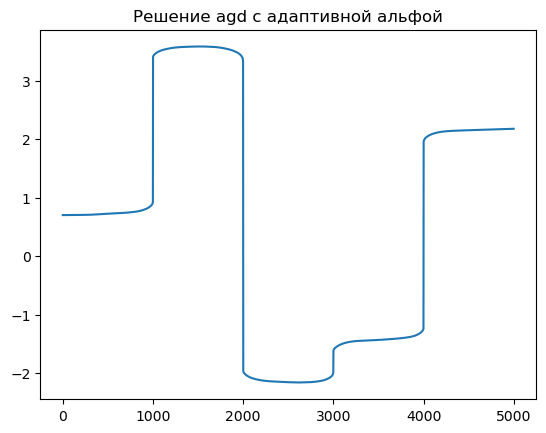

In [16]:
plt.plot(x_agd)
plt.title('Решение agd c адаптивной альфой')

Text(0.5, 1.0, 'Сходимость метода по норме градиента agd')

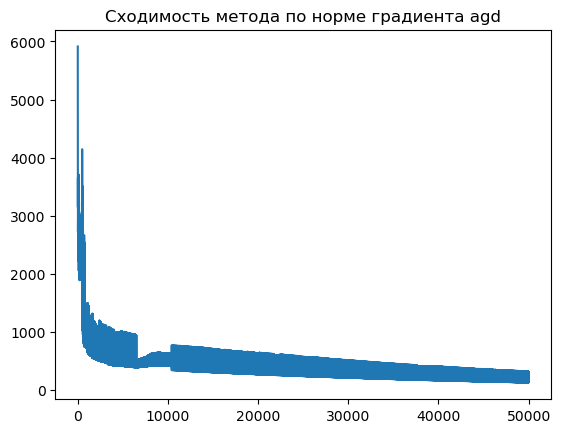

In [17]:
plt.plot([np.linalg.norm(grad(i)) for i in conv_agd ])
plt.title('Сходимость метода по норме градиента agd')

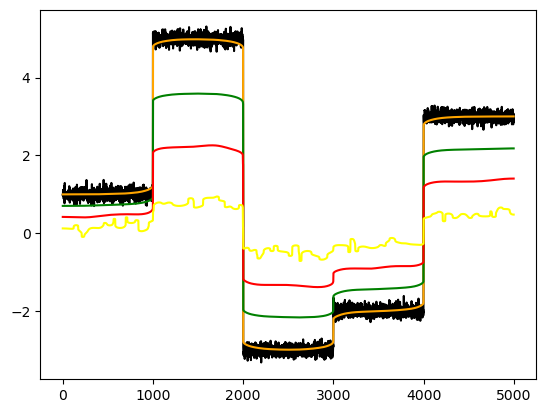

In [18]:
plt.plot(y , color='Black')
plt.plot(x.value , color='Orange') #Это решение cvxpy 
plt.plot(x_agd , color='Green')
plt.plot(x1_gd , color='Red')
#plt.plot(x2_gd , color='Yellow')
plt.plot(x3_gd , color='Yellow')

# Оценка времени работы алгоритмов

In [19]:
max_iter = 100

#### GD

In [20]:
%timeit gradient_descent(grad, x0, max_iter, tol, alpha)

13.1 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


##### Adaptive GD

In [21]:
%timeit adaptive_gradient_descent(grad, x0, max_iter, tol)

241 ms ± 5.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Вывод по GD c alpha=const:
    1)Алгоритм работает с приемлемой скоростью из-за векторизированной функции градиента,хотя медленнее CVXPY
    2)На параметрах alpha=0.000003 и 100.000 итерациях удалось получить хоть более менее адекватный результат
    3)Настройка параметров очень тонкая , алгоритм начинает сильно бросать даже при маленьких изменениях alpha.
        Большие значения alpha здесь совершенно не подходят
    4)Основной индикатор качества решения для меня была 2-я норма градиента в последней точке алгоритма 

# Вывод по Adaptive GD :
    - Если сравнивать GD и Адаптивный GD на одинаковом количестве итераций , то Aдаптивный GD более точный .
    
    -То есть адаптивный GD быстрее достиграет заданной точности чем обычный GD(!!с точки зрения итераций!!) 
    однако он требует гораздно больше фактического времени , так как в нем сидит вложенный цикл , который 
    на каждой итерации дополнительно считает оптимальную альфу , это и является причиной повышенного 
    времени работы алгоритма . Есть и другие подходы к выбору оптимальной альфы ,но всё равно 
    выбирая между обычным GD и адаптивным GD надо иметь в виду , что второй имеет все шансы работать 
    дольше первого , при этом меньше итерируясь . 

# Повторите эксперименты для  𝜀=10−2 и  𝜀=10−4

# EPSILON = 0.01

In [22]:
EPSILON = 0.01

#### CVXPY

In [23]:
z = cvx.Variable(len(y))

obj = cvx.Minimize(f_cvx(z))
prob = cvx.Problem(obj)

prob.solve(max_iters=5000,solver='ECOS')

print('Время на решение: {}'.format(prob.solution.attr['solve_time']))
print('Кол-во итераций: {}'.format(prob.solution.attr['num_iters']))
print('Невязка: {}'.format(prob.solution.attr['solver_specific_stats']['info']['pres']))
print('Решение: {}'.format(z.value))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(z.value)) ) )
print('Значение функции в точке решения = {}'.format(prob.value))

Время на решение: 0.220731988
Кол-во итераций: 28
Невязка: 2.8543846203657513e-09
Решение: [1.00303496 1.00304084 1.00306361 ... 3.00441297 3.0043857  3.00433076]
Длина градиента в последней точке алгоритма : 0.002946389665692232
Значение функции в точке решения = 839.0360374660092


/home/daniil/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Text(0.5, 1.0, 'Решение CVXPY  с eps=0.01')

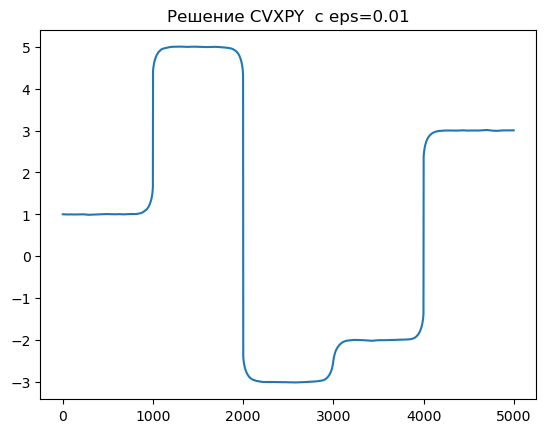

In [24]:
plt.plot(z.value)
plt.title('Решение CVXPY  с eps=0.01')

### GD c alpha=const

#### Первый вариант параметров

In [25]:
tol = 1e-5 
max_iter = 15000
alpha = 0.000003
x1_gd, x1_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x1_gd))
print('Кол-во итераций: {}'.format(len(x1_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x1_gd)) ) )

Решение: [-0.03335507 -0.03338447 -0.0334186  ...  0.13181688  0.1310458
  0.13061562]
Кол-во итераций: 15000
Длина градиента в последней точке алгоритма : 600.224521866431


#### Второй вариант параметров

In [26]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.000001
x2_gd, x2_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x2_gd))
print('Кол-во итераций: {}'.format(len(x2_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x2_gd)) ) )

Решение: [0.15285751 0.1529689  0.15320104 ... 0.48403694 0.48365787 0.48342707]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 367.4108399378853


#### Третий вариант параметров

In [27]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.0000009
x3_gd, x3_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x3_gd))
print('Кол-во итераций: {}'.format(len(x3_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x3_gd)) ) )

Решение: [0.12766422 0.12789377 0.12836129 ... 0.42410095 0.42371084 0.42347455]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 380.1851839283662


Text(0.5, 1.0, 'Решение GD')

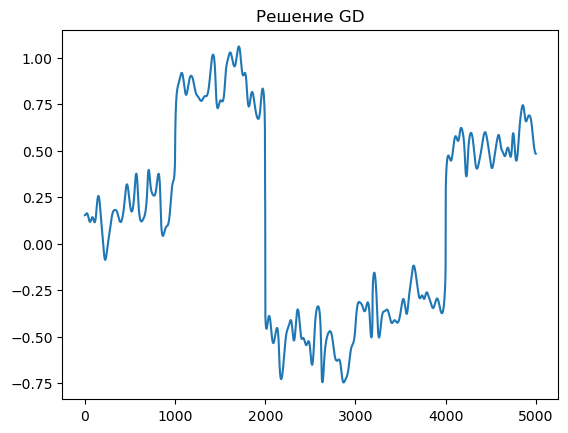

In [28]:
plt.plot(x2_gd)
plt.title('Решение GD')

Text(0.5, 1.0, 'Сходимость первого метода о норме градиента ')

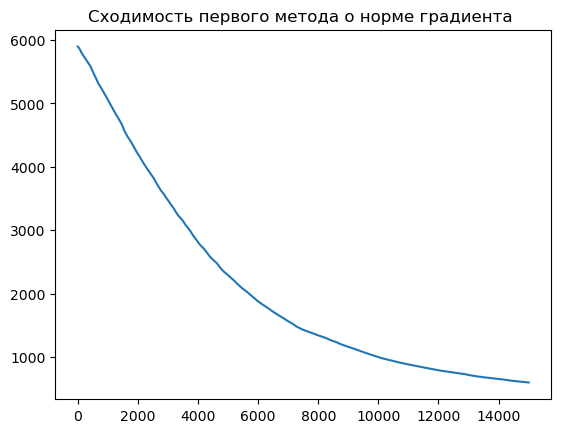

In [29]:
plt.plot([np.linalg.norm(grad(i)) for i in x1_conv_gd ])
plt.title('Сходимость первого метода о норме градиента ')

Text(0.5, 1.0, 'Сходимость второго метода о норме градиента ')

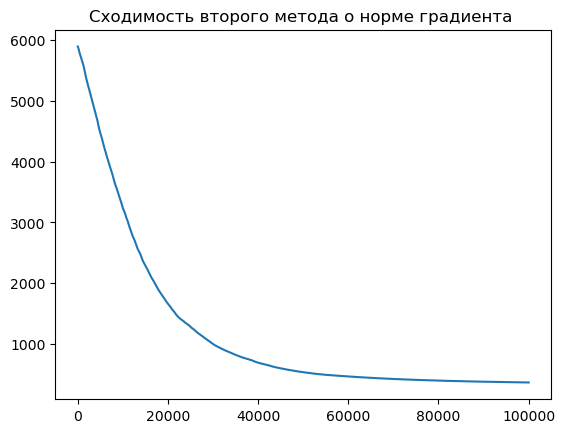

In [30]:
plt.plot([np.linalg.norm(grad(i)) for i in x2_conv_gd ])
plt.title('Сходимость второго метода о норме градиента ')

Text(0.5, 1.0, 'Сходимость третего метода о норме градиента ')

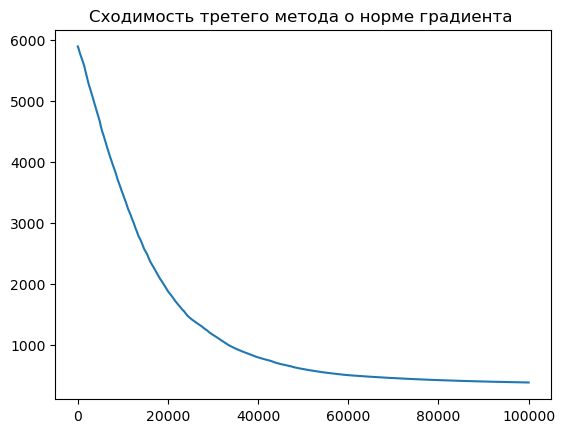

In [31]:
plt.plot([np.linalg.norm(grad(i)) for i in x3_conv_gd ])
plt.title('Сходимость третего метода о норме градиента ')

### GD c адаптивной alpha

In [32]:
tol = 1e-5 
max_iter = 20000
x_agd, conv_agd = adaptive_gradient_descent(grad, x0, max_iter, tol)
print('Решение: {}'.format(x_agd))
print('Кол-во итераций: {}'.format(len(conv_agd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x_agd)) ) )

Решение: [1.00228815 1.00229403 1.0023168  ... 3.00235721 3.00232992 3.00227499]
Кол-во итераций: 20000
Длина градиента в последней точке алгоритма : 0.4364282069301857


Text(0.5, 1.0, 'Решение agd ')

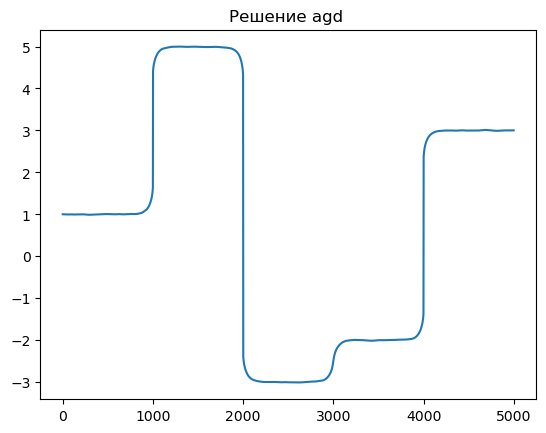

In [33]:
plt.plot(x_agd)
plt.title('Решение agd ')

Text(0.5, 1.0, 'Сходимость метода по норме градиента agd')

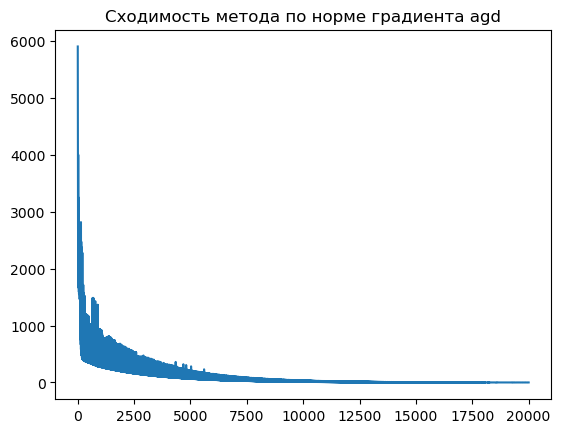

In [34]:
plt.plot([np.linalg.norm(grad(i)) for i in conv_agd ])
plt.title('Сходимость метода по норме градиента agd')

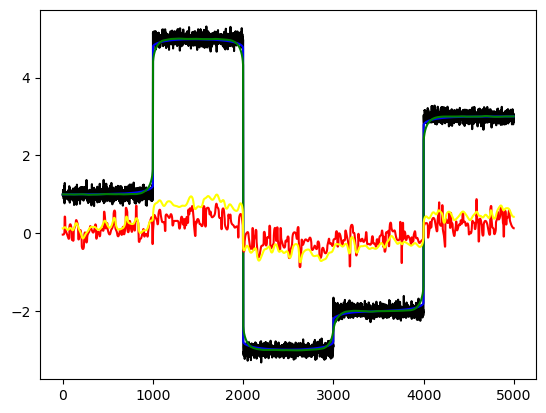

In [35]:
plt.plot(y , color='Black')
plt.plot(x.value , color='Blue') #Это решение cvxpy 
plt.plot(x_agd , color='Green')
plt.plot(x1_gd , color='Red')
#plt.plot(x2_gd , color='Yellow')
plt.plot(x3_gd , color='Yellow')

# EPSILON = 0.0001

In [36]:
EPSILON = 0.0001

#### CVXPY

In [37]:
c = cvx.Variable(len(y))

obj = cvx.Minimize(f_cvx(c))
prob = cvx.Problem(obj)

prob.solve(max_iters=5000,solver='ECOS')

print('Время на решение: {}'.format(prob.solution.attr['solve_time']))
print('Кол-во итераций: {}'.format(prob.solution.attr['num_iters']))
print('Невязка: {}'.format(prob.solution.attr['solver_specific_stats']['info']['pres']))
print('Решение: {}'.format(c.value))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(c.value)) ) )
print('Значение функции в точке решения = {}'.format(prob.value))

Время на решение: 0.205181588
Кол-во итераций: 25
Невязка: 3.897492829391094e-09
Решение: [1.01352429 1.0135244  1.01352471 ... 2.98922545 2.9892253  2.98922481]
Длина градиента в последней точке алгоритма : 0.002525962535607696
Значение функции в точке решения = 936.8878756936288


Text(0.5, 1.0, 'Решение CVXPY')

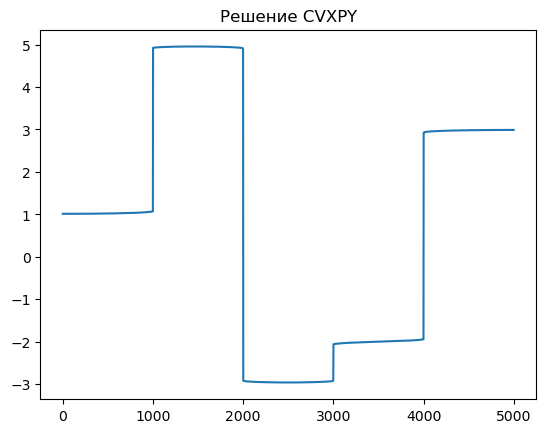

In [38]:
plt.plot(c.value)
plt.title('Решение CVXPY')

### GD c alpha=const

#### Первый вариант параметров

In [39]:
tol = 1e-5 
max_iter = 15000
alpha = 0.000003
x1_gd, x1_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x1_gd))
print('Кол-во итераций: {}'.format(len(x1_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x1_gd)) ) )

Решение: [-0.02208881 -0.02185501 -0.02202309 ...  0.17220482  0.17238883
  0.17215606]
Кол-во итераций: 15000
Длина градиента в последней точке алгоритма : 3114.822202281258


#### Второй вариант параметров

In [40]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.000001
x2_gd, x2_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x2_gd))
print('Кол-во итераций: {}'.format(len(x2_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x2_gd)) ) )

Решение: [0.14074116 0.14074189 0.14074347 ... 0.55319952 0.55319273 0.55318893]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 372.527444786139


#### Третий вариант параметров

In [41]:
tol = 1e-5 
max_iter = 100000 
alpha = 0.0000009
x3_gd, x3_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x3_gd))
print('Кол-во итераций: {}'.format(len(x3_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x3_gd)) ) )

Решение: [0.12219785 0.12219709 0.12219567 ... 0.487254   0.48724721 0.4872434 ]
Кол-во итераций: 100000
Длина градиента в последней точке алгоритма : 386.0725241097433


Text(0.5, 1.0, ' решение GD')

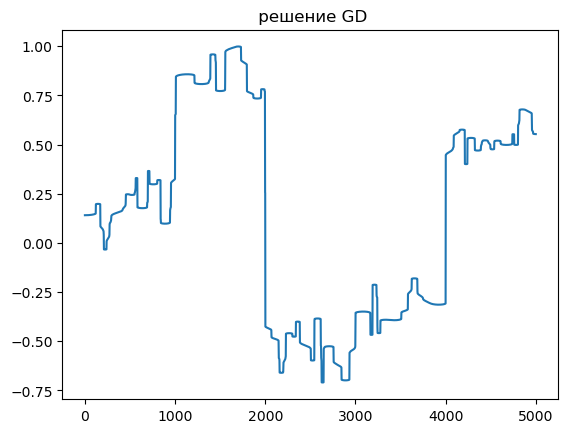

In [42]:
plt.plot(x2_gd)
plt.title(' решение GD')

Text(0.5, 1.0, 'Сходимость первого метода по норме градиента gd')

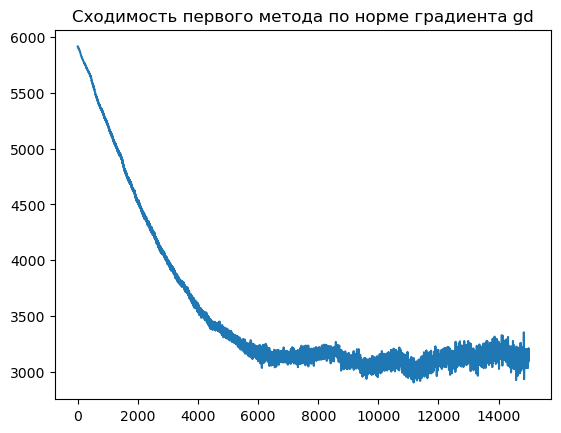

In [43]:
plt.plot([np.linalg.norm(grad(i)) for i in x1_conv_gd ])
plt.title('Сходимость первого метода по норме градиента gd')

Text(0.5, 1.0, 'Сходимость второго метода по норме градиента gd')

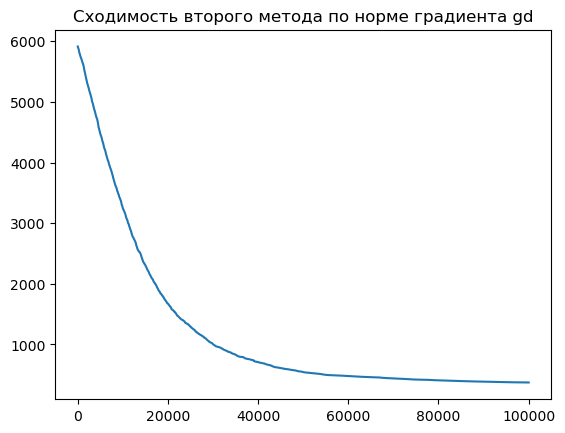

In [44]:
plt.plot([np.linalg.norm(grad(i)) for i in x2_conv_gd ])
plt.title('Сходимость второго метода по норме градиента gd')

Text(0.5, 1.0, 'Сходимость третьего метода по норме градиента gd')

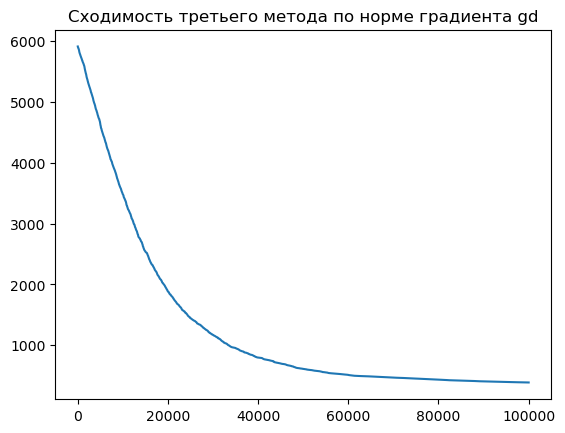

In [45]:
plt.plot([np.linalg.norm(grad(i)) for i in x3_conv_gd ])
plt.title('Сходимость третьего метода по норме градиента gd')

### GD c адаптивной alpha

In [46]:
tol = 1e-5 
max_iter = 50000
x_agd, conv_agd = adaptive_gradient_descent(grad, x0, max_iter, tol)
print('Решение: {}'.format(x_agd))
print('Кол-во итераций: {}'.format(len(conv_agd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x_agd)) ) )

Решение: [0.13147214 0.13148905 0.13144671 ... 0.51973342 0.51965819 0.51971047]
Кол-во итераций: 50000
Длина градиента в последней точке алгоритма : 1365.7000567206078


Text(0.5, 1.0, 'Решение agd')

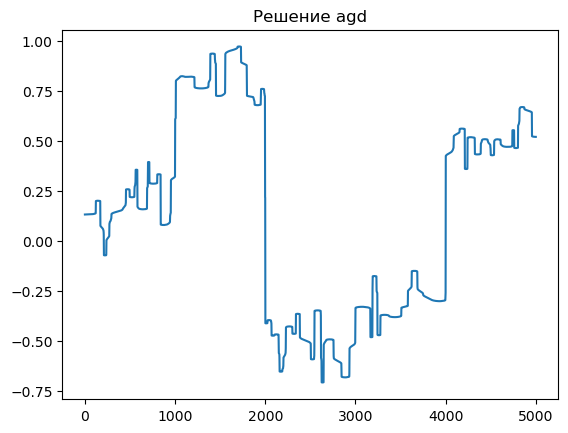

In [47]:
plt.plot(x_agd)
plt.title('Решение agd')

Text(0.5, 1.0, 'Сходимость метода по норме градиента agd')

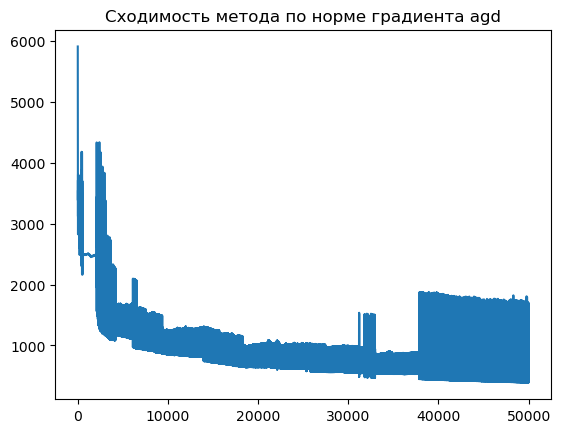

In [48]:
plt.plot([np.linalg.norm(grad(i)) for i in conv_agd ])
plt.title('Сходимость метода по норме градиента agd')

# Нарисуем y и x* . 
    x* стремится повторить y при Eps-> +inf
    x* стремится сгладить y при Eps->0

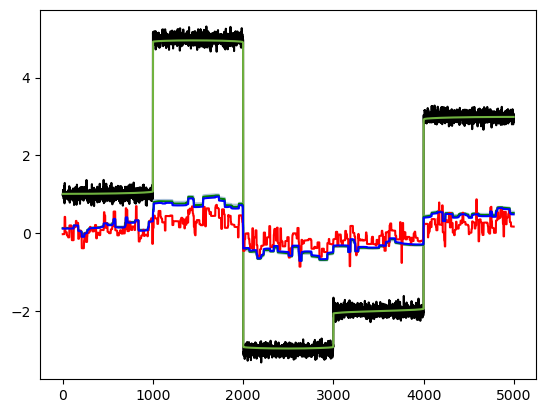

In [49]:
plt.plot(y , color='Black')
plt.plot(x2_gd , color='#acc2d9')
plt.plot(c.value , color='#70b23f')#Это решение cvxpy 
plt.plot(x_agd , color='Green')
plt.plot(x1_gd , color='Red')

plt.plot(x3_gd , color='Blue')

### Нарисуем все 3 решения CVXPY и поймём на что влияет EPSILON

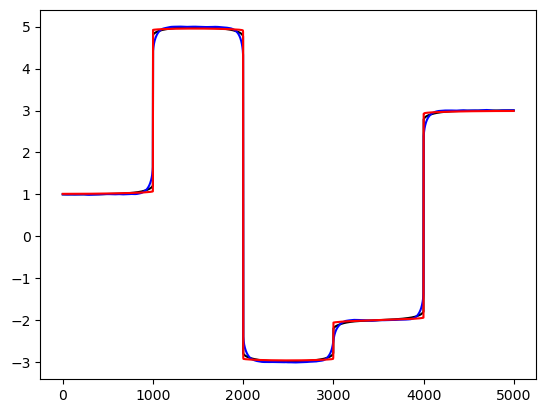

In [50]:
plt.plot(x.value , color = 'Black') # Eps = 0.001
plt.plot(z.value , color = 'Blue') # Eps = 0.01
plt.plot(c.value , color = 'Red') # Eps = 0.0001

<p style="align: center;"><img align=center
src="https://s1.hostingkartinok.com/uploads/images/2023/09/3f6ec082f595098ba7d5fac596029971.jpg" width=550 height=450/></p>


# Вывод по поводу параметра EPSILON:
    Если визуализировать функциональную взаимосвязь правого члена целевой функции то станет видно 
    что эпсилон - это штраф который накладывается за разности между соседними сленами ветора x.
    По оси x лежит параметр эпсилон , по оси y - размер разности между соседними членами , 
    по оси z - общая сумма штрафа . 
    Можно заметить , что при малых эпсилонах функция болезненно реагирует на "ступеньку" и сильно 
    штрафует за нее . С ростом параметра эпсилон штраф становится всё меньше и меньше . 
    
    Итого : чем больше эпислон , тем больше мы стремимся повторить вектор Y (в угоду минимизации второй нормы)
            чем меньше эпсилон , тем более гладкий график мы получаем (из-за большого штрафа за ступеньки)
    
